# Co je to Nanopore sekvenování?

## Jak to funguje?

- Nanopór je maličký otvor v tenké membráně.
- Do otvoru se pustí slabý elektrický proud.
- Když DNA prochází skrz, **každé písmeno DNA (A, T, C, G)** trochu změní proud.
- Tato změna se zaznamenává jako **průbeh signálu**.
- Počítač pak z těchto vln pozná, jaká písmena DNA šla dovnitř.

![DNA/RNA sequencng](https://a.storyblok.com/f/196663/640x360/86b5f57ecd/nanopore-sequencing-animation.gif/m/640x360/filters:format(webp))

Podívej se na krátké video (2 minuty):  
🔗 [Jak funguje nanopórové sekvenování – od Oxford Nanopore](https://www.youtube.com/watch?v=2C9gRz8OTR8)

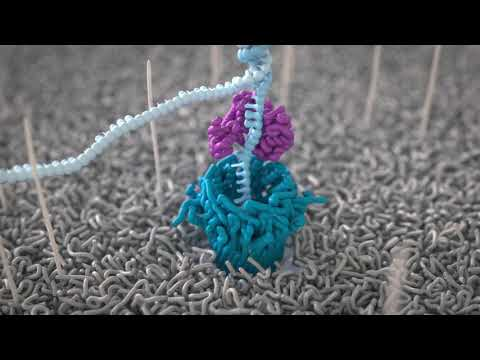

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("RcP85JHLmnI", width=800, height=450)

## Podíváme se na skutečný signál

V následujícím grafu uvidíme, jak vypadá **surový signál** ze sekvenátoru.

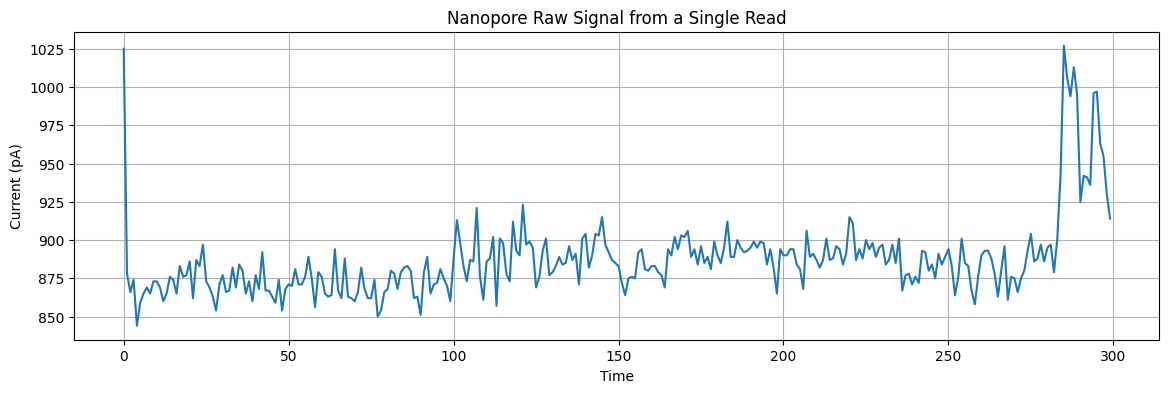

In [3]:
import pod5
import matplotlib.pyplot as plt
import numpy as np

# Load a read from a .pod5 file
file_path = "tmp.pod5"  # replace with your actual file path
with pod5.Reader(file_path) as reader:
    read = next(reader.reads())
    signal = read.signal

# Plot the raw signal
plt.figure(figsize=(14, 4))
plt.plot(signal[:300])  # Plot first 300 signal points
plt.title("Nanopore Raw Signal from a Single Read")
plt.xlabel("Time")
plt.ylabel("Current (pA)")
plt.grid(True)
plt.show()

### Otázky na zamyšlení:

**Proč se asi mění signál, když DNA prochází nanopórem?**

<details>
<summary>Odpověď</summary>

Každé písmeno DNA má jiný tvar a jinou velikost, takže ovlivňuje proud jinak. Když DNA prochází nanopórem, ovlivňuje proud iontů (např. Na⁺, Cl⁻), který jím prochází. Různé kombinace písmen DNA (tzv. k-mery) mají různý tvar a elektrické vlastnosti, takže každý z nich mění proud jiným způsobem. Počítač pak z těchto změn pozná, která písmena tam byla.

</details>

**Když dostaneme tento signál, jak bys z něj poznal, jaká písmena jsou v DNA?**

<details>
<summary>Odpověď</summary>
Počítač se to učí z tisíců příkladů pomocí umělé inteligence.

**Zkus si představit:**
Kdybys měl z poslechu hluku určit, co jede po silnici (auto, kolo, autobus), dokážeš to? Nanopór to dělá podobně – rozpoznává, co právě prošlo.
</details>

## Převod signálu na DNA sekvenci – Basecalling

Když molekula DNA prochází nanopórem, zaznamenáváme změny elektrického proudu. Tyto změny tvoří tzv. **surový signál** (anglicky *raw signal*), který je uložen v souborech typu `.pod5`.

Ale abychom zjistili, jaká písmena DNA (A, T, C, G) odpovídají tomuto signálu, potřebujeme **převodník** – ten se nazývá **basecaller**.

## Co dělá basecaller?

- Analyzuje průběh elektrického signálu
- Pomocí umělé inteligence a trénovaných modelů odhadne, jaké nukleotidy procházely nanopórem
- Výsledek je sekvence DNA ve formátu **FASTQ** – tedy:
  - Sekvence (např. `AGGCTTAC...`)
  - Kvalita každého písmena (číslem vyjádřená jistota)

Pro převod použijeme nástroj **Dorado** od Oxford Nanopore Technologies.

V další části nejprve ukážeme basecalling jednotlivých čtení v jednom .pod5 souboru, a poté zpracujeme všechna najednou.

In [ ]:
!python3 print_basecalled.py /home/lab33/researchers_night/dna_r10.4.1_e8.2_400bps_sup@v5.0.0/ /path/to/your/file.pod5 # TODO upravit cestu

Traceback (most recent call last):
  File "/home/vecerkov/Desktop/summer_school_workshop/print_basecalled.py", line 24, in <module>
    with pod5.Reader(first_pod5) as reader:
  File "/home/vecerkov/micromamba/envs/myenv/lib/python3.10/site-packages/pod5/reader.py", line 673, in __init__
    ) = self._open_arrow_table_handles(self._path)
  File "/home/vecerkov/micromamba/envs/myenv/lib/python3.10/site-packages/pod5/reader.py", line 707, in _open_arrow_table_handles
    raise FileNotFoundError(f"Failed to open pod5 file at: {path}")
FileNotFoundError: Failed to open pod5 file at: /path/to/your/file.pod5


### Co je ve FASTQ souboru?

Soubor `.fastq` obsahuje výsledky sekvenování – tedy čtení DNA. Každé čtení má 4 řádky:

1. `@` a název čtení
2. Sekvence DNA (např. `ACGTTG...`)
3. `+` jako oddělovač
4. Kvalita jednotlivých bází (čím vyšší znak, tím vyšší jistota)

In [5]:
!head -n 24 basecalled_reads.fastq # TODO upravit cestu

head: cannot open 'basecalled_reads.fastq' for reading: No such file or directory


### Zkus si: K jakému organismu patří náš vzorek?

1. Vyber jednu ze sekvencí výše
2. Zkopíruj ji a vlož do nástroje [NCBI BLAST (nucleotide)](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE_TYPE=BlastSearch&PROGRAM=blastn)
3. Stiskni "BLAST"
4. Sleduj, jak databáze najde podobné sekvence a řekne ti, odkud pochází

### Zamysli se

- Jsou některé čtení delší než jiné?
- Všimni si, že některá čtení mají horší kvalitu (nižší znaky ve 4. řádku), použij [tabulku vysvětlující  Phred skóre](https://en.wikipedia.org/wiki/Phred_quality_score)
- Co se asi stane, když pošleme do BLASTu krátké vs. dlouhé čtení?

<details>
<summary>Odpověď</summary>

- Ano, délka čtení se může lišit. Nanopore umožňuje číst velmi dlouhé úseky DNA, ale některá čtení mohou být přerušena dříve.
- Znaky ve 4. řádku ukazují kvalitu každé báze. Nižší znaky znamenají nižší jistotu – mohou být způsobeny šumem v signálu.
- Krátká čtení mají menší šanci najít jednoznačný výsledek v BLASTu – mohou se hodit k více oblastem v různých genomech. Delší čtení jsou často specifičtější a dají lepší nápovědu o původu vzorku.

</details>

## Jak se liší genetická informace zdravého člověka a onkopacienta?

### Co je to karyotyp a proč ho zkoumáme?

Každá lidská buňka (kromě pohlavních buněk) obsahuje 46 chromozomů – to je náš karyotyp. Chromozomy jsou "balíčky" DNA, které nesou naši genetickou informaci. Zdravé buňky mají kompletní a správně uspořádaný karyotyp – 23 párů chromozomů, žádné navíc, žádné chybějící části.

U nádorových buněk ale často dochází ke změnám – mohou mít některé chromozomy zdvojené, ztracené, přeskupené nebo přerušené. Takové změny označujeme jako chromozomální aberace, a jsou jedním z typických znaků rakovinných buněk. Právě proto se karyotyp nádorových buněk zkoumá – může nám napovědět, co je v buňce špatně a jak rakovina vznikla.

### Jak to zjistíme pomocí sekvenování

Pomocí nanopórového sekvenování DNA získáme dlouhé úseky genetické informace z jednotlivých chromozomů. Výsledkem je obrovské množství "čtení" – krátkých úseků DNA, které se zpětně skládají na jednotlivé chromozomy lidského genomu.

Při analýze sledujeme tzv. pokrytí (coverage) – tedy kolik čtení se mapuje na jednotlivé části každého chromozomu. Pokud má nějaký chromozom vyšší pokrytí, může to znamenat, že je v buňce zdvojený. Naopak nižší pokrytí může naznačovat ztrátu části nebo celého chromozomu.

### Proč porovnáváme zdravé a nádorové buňky?

Porovnáním karyotypu zdravých pacientů a onkopacientů můžeme zjistit, které chromozomy nebo jejich části jsou v nádorových buňkách změněné. To nám pomáhá pochopit, co se v buňkách děje při vzniku rakoviny, a může to být i důležitý krok ke zlepšení diagnostiky nebo léčby.

### Jak získáme pokrytí jednotlivých chromozomů?

Abychom mohli porovnat karyotyp zdravého a nemocného člověka, potřebujeme nejprve jejich sekvenovanou DNA zarovnat na referenční lidský genom – tedy na "mapu" správně uspořádané lidské DNA, kterou vědci sestavili.

Zarovnání na referenci: Pomocí bioinformatických nástrojů (např. minimap2) zarovnáme všechna přečtení DNA (tzv. "reads") ke správnému místu v lidském genomu.


In [ ]:
# nastavit cestu k souborum
# TODO upravit cesty k souborum
test1 = "/home/vecerkov/Desktop/summer_school_workshop/2025_07_15_NUVR_RB0/2025_07_15_NUVR_RB0/no_sample_id/20250715_1449_P2S-02648-B_PBC42512_57bb6767/fastq_pass/barcode06"
test2 = "/home/vecerkov/Desktop/summer_school_workshop/2025_07_15_NUVR_RB0/2025_07_15_NUVR_RB0/no_sample_id/20250715_1449_P2S-02648-B_PBC42512_57bb6767/fastq_pass/barcode08"

healthy_control_rep1_fastq = test1
cancer_sample1_rep1_fastq = test2
cancer_sample2_rep1_fastq = test2

healthy_control_rep2_fastq = test1
cancer_sample1_rep2_fastq = test1
cancer_sample2_rep2_fastq = test1

healthy_control_rep3_fastq = test2
cancer_sample1_rep3_fastq = test2
cancer_sample2_rep3_fastq = test2

reference_genome = "Homo_sapiens.GRCh38.dna.toplevel.fa"

In [ ]:
# spojime fastq soubory stejneho vzorku do jednoho souboru
# TODO upravit cesty k souborum
!cat "$healthy_control_rep1_fastq"/PBC42512_pass_barcode06_57bb6767_39d08f64_*.fastq.gz > healthy_control_rep1.fastq.gz
!cat "$cancer_sample1_rep1_fastq"/PBC42512_pass_barcode08_57bb6767_39d08f64_*.fastq.gz > cancer_sample1_rep1.fastq.gz
!cat "$cancer_sample2_rep1_fastq"/PBC42512_pass_barcode08_57bb6767_39d08f64_*.fastq.gz > cancer_sample2_rep1.fastq.gz

!cat "$healthy_control_rep2_fastq"/PBC42512_pass_barcode06_57bb6767_39d08f64_*.fastq.gz > healthy_control_rep2.fastq.gz
!cat "$cancer_sample1_rep2_fastq"/PBC42512_pass_barcode06_57bb6767_39d08f64_*.fastq.gz > cancer_sample1_rep2.fastq.gz
!cat "$cancer_sample2_rep2_fastq"/PBC42512_pass_barcode06_57bb6767_39d08f64_*.fastq.gz > cancer_sample2_rep2.fastq.gz

!cat "$healthy_control_rep3_fastq"/PBC42512_pass_barcode08_57bb6767_39d08f64_*.fastq.gz > healthy_control_rep3.fastq.gz
!cat "$cancer_sample1_rep3_fastq"/PBC42512_pass_barcode08_57bb6767_39d08f64_*.fastq.gz > cancer_sample1_rep3.fastq.gz
!cat "$cancer_sample2_rep3_fastq"/PBC42512_pass_barcode08_57bb6767_39d08f64_*.fastq.gz > cancer_sample2_rep3.fastq.gz

In [ ]:
# namapujeme cteni na referencni lidsky genom
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" healthy_control_rep1.fastq.gz | samtools sort -o healthy_control_rep1.sorted.bam && samtools index healthy_control_rep1.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample1_rep1.fastq.gz | samtools sort -o cancer_sample1_rep1.sorted.bam && samtools index cancer_sample1_rep1.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample2_rep1.fastq.gz | samtools sort -o cancer_sample2_rep1.sorted.bam && samtools index cancer_sample2_rep1.sorted.bam

!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" healthy_control_rep2.fastq.gz | samtools sort -o healthy_control_rep2.sorted.bam && samtools index healthy_control_rep2.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample1_rep2.fastq.gz | samtools sort -o cancer_sample1_rep2.sorted.bam && samtools index cancer_sample1_rep2.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample2_rep2.fastq.gz | samtools sort -o cancer_sample2_rep2.sorted.bam && samtools index cancer_sample2_rep2.sorted.bam

!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" healthy_control_rep3.fastq.gz | samtools sort -o healthy_control_rep3.sorted.bam && samtools index healthy_control_rep3.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample1_rep3.fastq.gz | samtools sort -o cancer_sample1_rep3.sorted.bam && samtools index cancer_sample1_rep3.sorted.bam
!/home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 "$reference_genome" cancer_sample2_rep3.fastq.gz | samtools sort -o cancer_sample2_rep3.sorted.bam && samtools index cancer_sample2_rep3.sorted.bam

[M::mm_idx_gen::55.890*1.74] collected minimizers
[M::mm_idx_gen::72.635*2.22] sorted minimizers
[M::main::72.635*2.22] loaded/built the index for 706 target sequence(s)
[M::mm_mapopt_update::74.244*2.19] mid_occ = 746
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 706
[M::mm_idx_stat::75.124*2.18] distinct minimizers: 100226345 (37.12% are singletons); average occurrences: 5.883; average spacing: 5.582; total length: 3291585349
[M::worker_pipeline::133.171*2.94] mapped 8252 sequences
[M::main] Version: 2.30-r1287
[M::main] CMD: /home/vecerkov/Desktop/summer_school_workshop/minimap2/minimap2 -ax map-ont -t 4 Homo_sapiens.GRCh38.dna.toplevel.fa healthy_control_rep1.fastq.gz
[M::main] Real time: 133.303 sec; CPU: 391.511 sec; Peak RSS: 11.711 GB
[M::mm_idx_gen::77.798*1.90] collected minimizers
[M::mm_idx_gen::96.619*2.29] sorted minimizers
[M::main::96.619*2.29] loaded/built the index for 706 target sequence(s)
[M::mm_mapopt_update::98.552*2.26] mid_occ = 746
[M::mm_idx_stat

#### Jak vypadají namapovaná čtení?

In [ ]:
# SPUSTIT IGV DESKTOP

Výpočet pokrytí (coverage): Poté spočítáme, kolik čtení připadá na každý chromozom nebo jeho část. Čím více přečtení na určitém místě, tím vyšší pokrytí.

Vykreslení grafu: Pokrytí zobrazíme v grafu – každý chromozom bude mít svůj sloupec nebo bod. Zdravý vzorek by měl mít zhruba rovnoměrné pokrytí všech chromozomů. Nádorový vzorek ale může mít výrazné výkyvy – některé chromozomy s vyšším nebo nižším pokrytím, což ukazuje na změny v počtu kopií chromozomů (copy number variations).

## Vykreslíme a porovnáme pokrytí jednotlivých chromozomů

Porovnáme pokrytí celých chromozomů.

In [ ]:
!samtools coverage healthy_control_rep1.sorted.bam | head -n 25 > healthy_control_rep1.coverage.tsv
!samtools coverage cancer_sample1_rep1.sorted.bam | head -n 25 > cancer_sample1_rep1.coverage.tsv
!samtools coverage cancer_sample2_rep1.sorted.bam | head -n 25 > cancer_sample2_rep1.coverage.tsv

!samtools depth healthy_control_rep2.sorted.bam | head -n 25 > healthy_control_rep2.coverage.tsv
!samtools depth cancer_sample1_rep2.sorted.bam | head -n 25 > cancer_sample1_rep2.coverage.tsv
!samtools depth cancer_sample2_rep2.sorted.bam | head -n 25 > cancer_sample2_rep2.coverage.tsv

!samtools depth healthy_control_rep3.sorted.bam | head -n 25 > healthy_control_rep3.coverage.tsv
!samtools depth cancer_sample1_rep3.sorted.bam | head -n 25 > cancer_sample1_rep3.coverage.tsv
!samtools depth cancer_sample2_rep3.sorted.bam | head -n 25 > cancer_sample2_rep3.coverage.tsv

In [2]:
import pandas as pd

In [ ]:
healthy_control_rep1_coverage_df = pd.read_csv("healthy_control_rep1.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
healthy_control_rep1_coverage_df.rename(columns={"coverage": "healthy_control_rep1_coverage"}, inplace=True)
cancer_sample1_rep1_coverage_df = pd.read_csv("cancer_sample1_rep1.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample1_rep1_coverage_df.rename(columns={"coverage": "cancer_sample1_rep1_coverage"}, inplace=True)
cancer_sample2_rep1_coverage_df = pd.read_csv("cancer_sample2_rep1.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample2_rep1_coverage_df.rename(columns={"coverage": "cancer_sample2_rep1_coverage"}, inplace=True)

healthy_control_rep2_coverage_df = pd.read_csv("healthy_control_rep2.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
healthy_control_rep2_coverage_df.rename(columns={"coverage": "healthy_control_rep2_coverage"}, inplace=True)
cancer_sample1_rep2_coverage_df = pd.read_csv("cancer_sample1_rep2.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample1_rep2_coverage_df.rename(columns={"coverage": "cancer_sample1_rep2_coverage"}, inplace=True)
cancer_sample2_rep2_coverage_df = pd.read_csv("cancer_sample2_rep2.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample2_rep2_coverage_df.rename(columns={"coverage": "cancer_sample2_rep2_coverage"}, inplace=True)

healthy_control_rep3_coverage_df = pd.read_csv("healthy_control_rep3.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
healthy_control_rep3_coverage_df.rename(columns={"coverage": "healthy_control_rep3_coverage"} inplace=True)
cancer_sample1_rep3_coverage_df = pd.read_csv("cancer_sample1_rep3.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample1_rep3_coverage_df.rename(columns={"coverage": "cancer_sample1_rep3_coverage"}, inplace=True)
cancer_sample2_rep3_coverage_df = pd.read_csv("cancer_sample2_rep3.coverage.tsv", sep="\t", usecols = ["#rname", "startpos", "endpos", "coverage"])
cancer_sample2_rep3_coverage_df.rename(columns={"coverage": "cancer_sample2_rep3"}, inplace=True)

In [ ]:
# healthy_control_rep1_coverage_df.merge(cancer_sample1_rep1_coverage_df).merge(cancer_sample2_rep1_coverage_df)
healthy_control_rep1_coverage_df.merge(cancer_sample1_rep1_coverage_df).merge(cancer_sample2_rep1_coverage_df).merge(healthy_control_rep2_coverage_df).merge(cancer_sample1_rep2_coverage_df).merge(cancer_sample2_rep2_coverage_df).merge(healthy_control_rep3_coverage_df).merge(cancer_sample1_rep3_coverage_df).merge(cancer_sample2_rep3_coverage_df)

,#rname,startpos,endpos,healthy_control_rep1,cancer_sample1_rep1,cancer_sample2_rep1
0,1,1,248956422,0.692454,0.692454,0.692454
1,2,1,242193529,0.951888,0.951888,0.951888
2,3,1,198295559,0.788534,0.788534,0.788534
3,4,1,190214555,0.822632,0.822632,0.822632
4,5,1,181538259,0.758634,0.758634,0.758634
5,6,1,170805979,0.775689,0.775689,0.775689
6,7,1,159345973,0.779241,0.779241,0.779241
7,8,1,145138636,0.919566,0.919566,0.919566
8,9,1,138394717,0.671291,0.671291,0.671291
9,10,1,133797422,0.863999,0.863999,0.863999


In [ ]:
!samtools depth healthy_control_rep1.sorted.bam > healthy_control_rep1.depth.tsv
!samtools depth cancer_sample1_rep1.sorted.bam > cancer_sample1_rep1.depth.tsv
!samtools depth cancer_sample2_rep1.sorted.bam > cancer_sample2_rep1.depth.tsv

# !samtools depth healthy_control_rep2.sorted.bam > healthy_control_rep2.depth.tsv
# !samtools depth cancer_sample1_rep2.sorted.bam > cancer_sample1_rep2.depth.tsv
# !samtools depth cancer_sample2_rep2.sorted.bam > cancer_sample2_rep2.depth.tsv

# !samtools depth healthy_control_rep3.sorted.bam > healthy_control_rep3.depth.tsv
# !samtools depth cancer_sample1_rep3.sorted.bam > cancer_sample1_rep3.depth.tsv
# !samtools depth cancer_sample2_rep3.sorted.bam > cancer_sample2_rep3.depth.tsv

In [ ]:
depth_df = pd.read_csv("healthy_control_rep1.depth.bed") # TODO trva moc dlouho
depth_df